<br>Model from:
https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

-----------------------------------------
# Data visualization

In [1]:
import sys
sys.executable

'/usr/bin/python3'

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload

import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread 
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.nasnet import NASNetMobile
# from keras.applications import NASNetMobile
# from keras.applications.xception import Xception
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average
from keras.layers import Input, Concatenate, GlobalMaxPooling2D, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam
from keras.models import load_model
from keras import utils as np_utils
from livelossplot import PlotLossesKeras
import tensorflow as tf

import cv2

sys.path.insert(0, '../')
from src.dataGenerator import *

# import src.constants

Using TensorFlow backend.


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
# %load_ext tensorboard.notebook


In [11]:
# Output files
OUTPUT_DIR = "output_model2_2_tensorboard_lr/"
!mkdir {OUTPUT_DIR}

OUTPUT_TENSORBOARD_DIR = OUTPUT_DIR+"/logs/"
# !mkdir output_model2_2/logs/
# !tensorboard --logdir=output_model2_2/logs/

# MODEL_SUMMARY_FILE = OUTPUT_DIR + "model_summary.txt"
MODEL_PLOT_FILE = OUTPUT_DIR + "model_plot.png"

# Path to images
DATA_DIR = "../data"

TRAINING_LOGS_FILE_2 = OUTPUT_DIR + "training_logs_aug.csv"
MODEL_FILE_2 = OUTPUT_DIR + "model_aug.h5"
TRAINING_PLOT_FILE_2 = OUTPUT_DIR + "training_aug.png"
VALIDATION_PLOT_FILE_2 = OUTPUT_DIR + "validation_aug.png"
ROC_PLOT_FILE_2 = OUTPUT_DIR + "roc_aug.png"

KAGGLE_SUBMISSION_FILE_2 = OUTPUT_DIR + "kaggle_submission_aug.csv"

# Hyperparams
TRAINING_RATIO = 0.9
IMAGE_SIZE = 96
EPOCHS = 1
BATCH_SIZE = 192
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

mkdir: cannot create directory ‘output_model2_2_tensorboard_lr/’: File exists


In [12]:
data = pd.read_csv(DATA_DIR + '/train_labels.csv')
print(data['label'].value_counts())
training_data, validation_data = train_test_split(data, train_size=TRAINING_RATIO, stratify=data['label'])
print(training_data['label'].value_counts())
print(validation_data['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64
0    117817
1     80205
Name: label, dtype: int64
0    13091
1     8912
Name: label, dtype: int64


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
# Parameters
params = {'dim': (IMAGE_SIZE, IMAGE_SIZE),
          'batch_size': BATCH_SIZE,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'augmentation': True}

training_generator_with_aug = DataGenerator(training_data.id, training_data.label, **params)
validation_generator_with_aug = DataGenerator(validation_data.id, validation_data.label, **params)

Data augmentation enabled
Data augmentation enabled


In [14]:
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler
from time import time
import math

# learning rate schedule
def step_decay(epoch):
#     initial_lrate = 0.001 # Adam optimizer
    initial_lrate = 0.000008 # last value of lr
    # drop it on 0.1 every two epochs         
    drop = 0.75 
    epochs_drop = 1.0
    print("start of step_decay")
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    print("epoch: %d, learning rate = %.6f" % (epoch, lrate))
    return lrate

# Model
def create_model(file = ''):
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.5

    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                     input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Conv2D(first_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(256, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, activation = "sigmoid"))
    
    if (os.path.exists(file) == True):
        print("Load model from file: ", file)
        model = load_model(file)

    # Compile the model
    model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
    model.summary()

    plot_model(model,
               to_file=MODEL_PLOT_FILE,
               show_shapes=True,
               show_layer_names=True)
    
    return model

def train(model, training_generator, validation_generator, model_file, logs_file):

    tensorboard = TensorBoard(log_dir=OUTPUT_TENSORBOARD_DIR+"/{}".format(time()))
    
    lr_sched = LearningRateScheduler(step_decay)

    model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6,
                    epochs=EPOCHS,
                            callbacks=[PlotLossesKeras(plot_extrema=False),
                                        ModelCheckpoint(model_file,
                                                     monitor='val_acc',
                                                     verbose=VERBOSITY,
                                                     save_best_only=True,
                                                     mode='max'),
                                         CSVLogger(logs_file,
                                                   append=False,
                                                   separator=';'),
                                         tensorboard,
                                         lr_sched])
    
    
    

In [15]:
for i in range (13):
    step_decay(i)

start of step_decay
epoch: 0, learning rate = 0.000008
start of step_decay
epoch: 1, learning rate = 0.000006
start of step_decay
epoch: 2, learning rate = 0.000005
start of step_decay
epoch: 3, learning rate = 0.000003
start of step_decay
epoch: 4, learning rate = 0.000003
start of step_decay
epoch: 5, learning rate = 0.000002
start of step_decay
epoch: 6, learning rate = 0.000001
start of step_decay
epoch: 7, learning rate = 0.000001
start of step_decay
epoch: 8, learning rate = 0.000001
start of step_decay
epoch: 9, learning rate = 0.000001
start of step_decay
epoch: 10, learning rate = 0.000000
start of step_decay
epoch: 11, learning rate = 0.000000
start of step_decay
epoch: 12, learning rate = 0.000000


In [16]:
model_with_aug = create_model(MODEL_FILE_2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Load model from file:  output_model2_2_tensorboard_lr/model_aug.h5
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46

/home/yevhenp/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1, right=1
  ret = ax.set_xlim(*args, **kwargs)


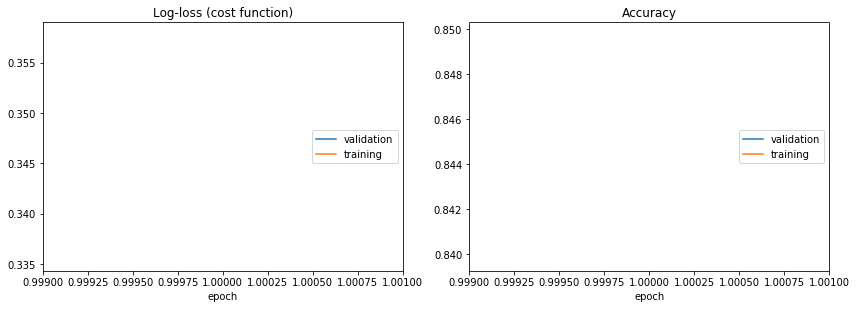


Epoch 00001: val_acc improved from -inf to 0.84978, saving model to output_model2_2_tensorboard_lr/model_aug.h5


In [17]:
history = train(model = model_with_aug, 
            training_generator = training_generator_with_aug,
            validation_generator = validation_generator_with_aug,
            model_file = MODEL_FILE_2,
            logs_file = TRAINING_LOGS_FILE_2)

In [18]:
def plot_epochs(history, training_plot_file, validation_plot_file):
    # Training plots
    epochs = [i for i in range(1, len(history.history['loss'])+1)]

    plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
    plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
    plt.legend(loc='best')
    plt.title('training')
    plt.xlabel('epoch')
    plt.savefig(training_plot_file, bbox_inches='tight')
    plt.close()

    plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
    plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
    plt.legend(loc='best')
    plt.title('validation')
    plt.xlabel('epoch')
    plt.savefig(validation_plot_file, bbox_inches='tight')
    plt.close()

In [19]:
def plot_AUC(model, testing_generator, model_file, plot_file):
    # ROC testing plot
#     model.load_weights(model_file)
    predictions = model.predict_generator(testing_generator, steps=len(testing_generator), verbose=VERBOSITY)
#     print(len(testing_generator))
#     print(testing_generator.classes.shape)
#     print(predictions.shape)
#     print(predictions)
    false_positive_rate, true_positive_rate, threshold = roc_curve(testing_generator.classes, predictions)
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    
    print("False positive: ", false_positive_rate)
    print("True positive: ", true_positive_rate)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    plt.savefig(plot_file, bbox_inches='tight')
    plt.close()


In [20]:
def test(model, file):
    testing_files = glob(os.path.join('data/test/','*.tif'))
    submission = pd.DataFrame()
    for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
        data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
        data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[2].split(".")[0])
        data_frame['image'] = data_frame['path'].map(imread)
        images = np.stack(data_frame.image, axis=0)
        predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
        predictions = np.array(predicted_labels)
        data_frame['label'] = predictions
        submission = pd.concat([submission, data_frame[["id", "label"]]])
    submission.to_csv(file, index=False, header=True)

In [21]:
# Parameters
params = {'dim': (IMAGE_SIZE, IMAGE_SIZE),
          'batch_size': BATCH_SIZE,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': False,
          'augmentation': False}

testing_generator = DataGenerator(validation_data.id, validation_data.label, **params)
# plot_epochs(history, TRAINING_PLOT_FILE_1, VALIDATION_PLOT_FILE_1)

114/114 [==============================] - 12s 109ms/step
False positive:  [0.         0.         0.         ... 0.95575697 0.95591059 1.        ]
True positive:  [0.         0.00338257 0.00417183 ... 1.         1.         1.        ]


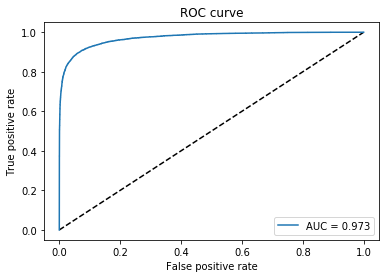

In [22]:
plot_AUC(model_with_aug, testing_generator, MODEL_FILE_2, ROC_PLOT_FILE_2)

In [23]:
# %load_ext tensorboard.notebook
# # os.makedirs(OUTPUT_TENSORBOARD_DIR, exist_ok=True)

# %tensorboard --logdir {OUTPUT_TENSORBOARD_DIR}


In [24]:
test(model = model_with_aug, file = KAGGLE_SUBMISSION_FILE_2)